In [1]:
%matplotlib notebook
from Bio import Entrez
from Bio import Medline
import pandas as pd
import time
import numpy as np
from ratelimiter import RateLimiter
import pubmed_parser as pp
import nltk
import matplotlib
Entrez.email = 'amanda.sawyer@nih.gov'
api_key = '86d72be66a4381e2e22c704615cbb9620c08'

In [8]:
proposedTermsPath = 'SP and SDOH Prioritized New Concepts.xlsx'
proposedTerms = pd.read_excel(proposedTermsPath)

### 1. Title and Title/Abstract Posting from PubMed

In [9]:
@RateLimiter(max_calls=10, period=1)
def getPubMedTitleTotal (term):
    termCounts = 0
    
    try:
        searchstring = term+' [ti]'
        handle = Entrez.esearch(db='pubmed', term=searchstring)
        result = Entrez.read(handle)
        handle.close()
        termCounts = result['Count']
    except:
        print("Error:", searchstring)
            
    return termCounts

@RateLimiter(max_calls=10, period=1)
def getPubMedTIABTotal (term):
    termCounts = 0
    
    try:
        searchstring = term+' [tiab]'
        handle = Entrez.esearch(db='pubmed', term=searchstring)
        result = Entrez.read(handle)
        handle.close()
        termCounts = result['Count']
    except:
        print("Error:", searchstring)
            
    return termCounts

In [10]:
proposedTerms

,Prioritized New Concept,Similar MeSH Terms,Parents in BSSO Module,skos:definition,rdfs:seeAlso,rdfs:comment,PubMed Counts (Concept Level),SDOH Association,SP Association,Total Association,...,OBSSR Measures,Encyclopedia,ODPHP,WHO,PhenX Toolkit,RCDC-SDOH,RCDC-Homelessness,RCDC-Homicide,NIMHD,Note
0,Social Processes,NaN,Sociological Factors [I01.880.853],NaN,NaN,RCDC (SDOH category),1949,19,NaN,NaN,...,No,No,No,No,No,Yes,No,No,No,Top 40
1,Social Determinants,Social Determinants of Health,Sociological Factors [I01.880.853],NaN,NaN,RCDC (SDOH category),3462,596,13.0,609.0,...,No,No,No,No,No,Yes,No,No,No,Top 40
2,Socioeconomics,Socioeconomic Factors,Socioeconomic Factors [I01.880.853.996];Socioe...,NaN,NaN,RCDC (SDOH category),55672,335,44.0,379.0,...,No,No,No,No,No,Yes,No,No,No,Top 40
3,Health Inequities,Health Status Disparities;Healthcare Disparities,Inequalities in Health,Health inequities are avoidable inequalities i...,https://www.who.int/social_determinants/thecom...,NaN,2015,300,4.0,304.0,...,No,No,No,No,No,No,No,No,No,Top 40
4,Social Factors,Sociological Factors,Sociological Factors [I01.880.853],NaN,NaN,RCDC (SDOH category),9542,138,50.0,188.0,...,No,No,No,No,No,Yes,No,No,No,Top 40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Leadership Role,Leadership;Role,Leadership;Role,"1. structurally, the position occupied by the ...",https://dictionary.apa.org/leadership-role,NaN,2314,7,3.0,10.0,...,No,No,No,No,No,No,No,No,No,NaN
103,Interpersonal Violence,Violence,Abuse and Neglect,NaN,NaN,RCDC (SDOH category),1828,8,2.0,10.0,...,No,No,No,No,No,Yes,No,No,No,NaN
104,Cultural Sensitivity,Cultural Competency,Cultural Competency,"awareness and appreciation of the values, norm...",https://dictionary.apa.org/cultural-sensitivity,RCDC (SDOH category),1098,9,1.0,10.0,...,No,No,No,No,No,Yes,No,No,No,NaN
105,Sense of Community,Community,Community;Social Groups,"a feeling that members have of belonging, a fe...",https://psycnet.apa.org/record/1987-03834-001,NaN,888,8,2.0,10.0,...,No,No,No,No,No,No,No,No,No,NaN


In [5]:
proposedTerms['Title Count'] = proposedTerms['Prioritized New Concept'].apply(getPubMedTitleTotal)
proposedTerms['Title Abstract Count'] = proposedTerms['Prioritized New Concept'].apply(getPubMedTIABTotal)

In [7]:
proposedTerms.to_csv(r'C:\Users\sawyerar\Documents\Preprints\MeSH Automation - Fall.csv', index = False)

### 2. PI and MN from PubMed

In [2]:
@RateLimiter(max_calls=10, period=1)
def getPMIDs (term) :
    handle_test = Entrez.esearch(db='pubmed', term=term+'[ti]', retmax = 1000)
    result_test = Entrez.read(handle_test)
    handle_test.close()
    pmid = result_test['IdList']
    return pmid

@RateLimiter(max_calls=10, period=1)
def returnPMRecords (ids) :
    tester = []
    rate_limiter = RateLimiter(max_calls=3, period=1)

    for x in ids :
        with rate_limiter:
            try:
                tester.append(pp.parse_xml_web(x, save_xml=False))
            except: pass
    return tester

In [ ]:
newterm = input("Enter search term:")
ids = getPMIDs(newterm)
tester = returnPMRecords(ids)

Enter search term:Chronic Migraine


In [16]:
#created a df
newTermDF = pd.DataFrame(tester)
#split keywords on ;
newTermDF['keywordssplit'] = newTermDF.apply(lambda row: row.keywords.split(';'), axis = 1)
#each keyword gets its own row
newTermDF = newTermDF.explode('keywordssplit')

In [17]:
#created a df for frequency of terms
frequency = pd.DataFrame()
frequency['Term Frequency'] = newTermDF['keywordssplit'].value_counts()
frequency['Percentage'] = round((frequency['Term Frequency'] / newTermDF['keywordssplit'].value_counts().sum()) * 100, 2)
frequency = frequency.reset_index()
frequency[:10]

,index,Term Frequency,Percentage
0,D006801:Humans,478,6.90
1,D015994:Incidence,391,5.65
2,D005260:Female,320,4.62
3,D008297:Male,287,4.15
4,D008875:Middle Aged,225,3.25
5,D000328:Adult,221,3.19
6,D000368:Aged,167,2.41
7,D012307:Risk Factors,115,1.66
8,D000293:Adolescent,107,1.55
9,D002648:Child,86,1.24


In [9]:
top15 = frequency[:14]
total = top15['Term Frequency'].sum()

In [10]:
sizes = top15['Term Frequency'] / total * 100
sizes = sizes.tolist()
names = top15['index']
names = names.tolist()

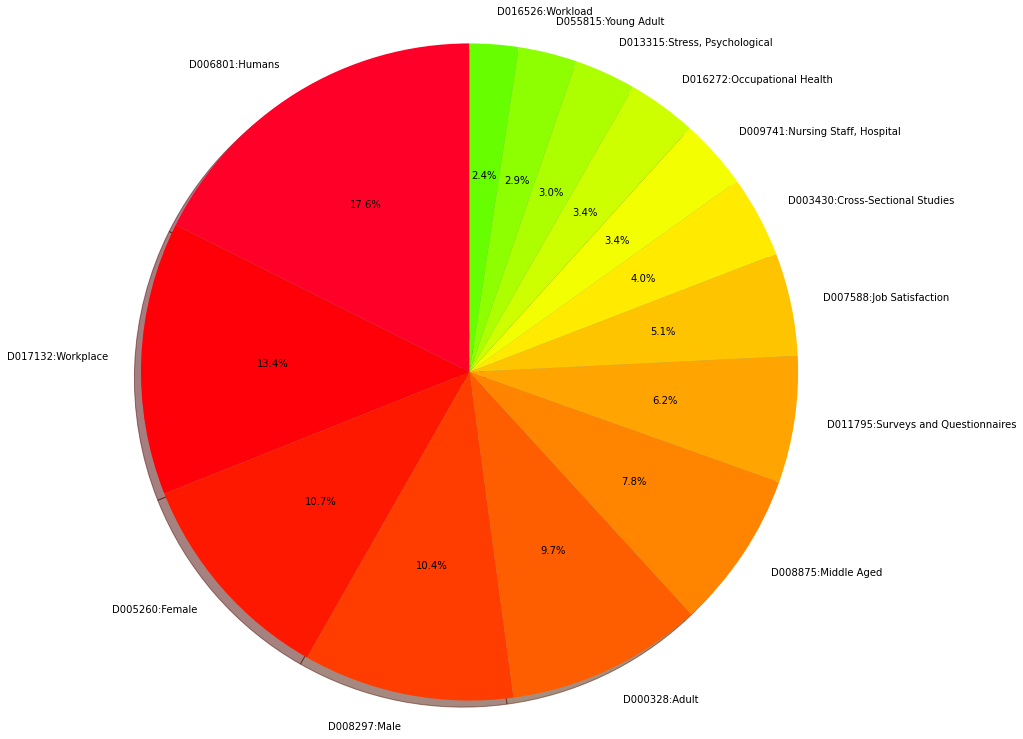

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm

labels = names
sizes = sizes
cs=cm.gist_rainbow(np.arange(40)/40.)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=cs, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(13, 13)
plt.show()